## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [3]:
import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt
from os import path

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, VariationalLFM, generate_multioutput_rbf_gp
from lafomo.plot import Plotter
from lafomo.trainers import VariationalTrainer
from lafomo.utilities.data import p53_ground_truth
from lafomo.utilities.torch import is_cuda

Let's start by importing our dataset...

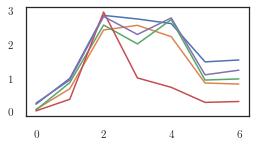

In [4]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])

Differential equation here: ....

Since this is an ordinary differential equation (ODE), we inherit from the `OrdinaryLFM` class.

In [5]:
from abc import abstractmethod
import gpytorch

class GradientMatchingLFM(VariationalLFM):
    """
    Variational approximation for an LFM based on an ordinary differential equation (ODE).
    Inheriting classes must override the `odefunc` function which encodes the ODE.
    """

    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.nfe = 0
        self.f = None

    def initial_state(self):
        initial_state = torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)
        initial_state = initial_state.cuda() if is_cuda() else initial_state
        return initial_state #initial_state.repeat(self.config.num_samples, 1, 1)  # Add batch dimension for sampling
        # if self.config.initial_conditions: TODO:
        #     h = self.initial_conditions.repeat(h.shape[0], 1, 1)

    def forward(self, t, step_size=1e-1, return_samples=False):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0

        # Get GP outputs
        # t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)
        t_f = t
        q_f = self.gp_model(t_f)

        h0 = self.initial_state()
        h0 = h0.unsqueeze(0).repeat(self.config.num_samples, 1, 1)
        self.f = q_f.rsample(torch.Size([self.config.num_samples])).permute(0, 2, 1)  # (S, I, T)
        self.f = self.G(self.f)


        # h_samples = odeint(self.odefunc, h0, t, method='rk4', options=dict(step_size=step_size)) # (T, S, num_outputs, 1)
        h_samples = self.odefunc(t_f, h0)

        self.f = None
        # self.t_index = None
        # self.last_t = None
        if return_samples:
            return h_samples

        h_mean = torch.mean(h_samples, dim=0).squeeze(-1) # shape was (#outputs, #T, 1) .permute(1, 0, 2)
        h_var = torch.var(h_samples, dim=0).squeeze(-1) + 1e-7
        h_mean = self.decode(h_mean)
        # TODO: make distribution something less constraining
        h_covar = torch.diag_embed(h_var)
        batch_mvn = gpytorch.distributions.MultivariateNormal(h_mean, h_covar)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

    def decode(self, h_out):
        return h_out

    @abstractmethod
    def odefunc(self, t, h):
        """
        Parameters:
            h: shape (num_samples, num_outputs, 1)
        """
        pass

    def G(self, f):
        return f.repeat(1, self.num_outputs, 1)  # (S, I, t)

class TranscriptionLFM(GradientMatchingLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.basal_rate = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h
        # print(h.shape, t.shape, self.f.shape)
        dh = self.basal_rate + self.sensitivity * self.f - decay

        return dh


In [6]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, 13, 80, dtype=torch.float32)
step_size = 1e-1
num_training = dataset.m_observed.shape[-1]

gp_model = generate_multioutput_rbf_gp(num_tfs, inducing_points)

lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)

plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

class P53ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        super().after_epoch()
        # self.cholS.append(self.lfm.q_cholS.detach().clone())
        # self.mus.append(self.lfm.q_m.detach().clone())
        with torch.no_grad():
            # TODO can we replace these with parameter transforms like we did with lengthscale
            # self.lfm.sensitivity.clamp_(0, 20)
            self.lfm.basal_rate.clamp_(0, 20)
            self.lfm.decay_rate.clamp_(0, 20)
            self.lfm.sensitivity[3] = np.float64(1.)
            self.lfm.decay_rate[3] = np.float64(0.8)

track_parameters = [
    'basal_rate',
    'decay_rate',
    'sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
use_natural = False
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.03)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]
trainer = P53ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)

/Users/jacob/Documents/proj/reggae/lafomo/models/variational_lfm.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


(5, 97)


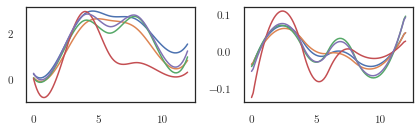

In [7]:
from scipy.interpolate import interp1d
data = next(iter(trainer.data_loader))
t = data[0][0]
y = data[1][0]
def calc(N, d):
    return (N - 1) * (d + 1) + 1
t_interpolate = torch.linspace(min(t), max(t), calc(13, 7))

y_interpolate = interp1d(data[0][0], data[1], axis=1, kind='cubic')
y_interpolate = y_interpolate(t_interpolate)
denom = t[1] - t[0]
y_grad = np.gradient(y_interpolate, denom, axis=1)

fig, axes = plt.subplots(ncols=2, figsize=(6, 2))
for i in range(5):
    axes[0].plot(t_interpolate, y_interpolate[i])
    axes[1].plot(t_interpolate, y_grad[i])
plt.tight_layout()
print(y_grad.shape)

In [40]:
x, y = next(iter(trainer.data_loader))
x = x[0]
y_grad_target = torch.tensor([y_grad[:, i*7+i] for i in range(13)])
y_grad_target = y_grad_target[::2]
t_grad = torch.tensor([t_interpolate[i*7+i] for i in range(13)])
t_grad = t_grad[::2]

lfm.train()
# Pretrain
def single_epoch(epoch=0):
    optimizers[0].zero_grad()

    grads = lfm(x)
    log_likelihood, kl_divergence, _ = lfm.loss_fn(grads, y_grad_target)
    loss = - (log_likelihood - kl_divergence)

    if (i % 10) == 0:
        print(i, 'loss', loss.item(), lfm.gp_model.covar_module.lengthscale.item())
    loss.backward()
    optimizers[0].step()
    # print('lenghscale', lfm.gp_model.covar_module.lengthscale)
    # print(lfm.basal_rate, lfm.decay_rate, lfm.sensitivity)
    with torch.no_grad():
        # TODO can we replace these with parameter transforms like we did with lengthscale
        lfm.sensitivity.clamp_(0, 20)
        lfm.basal_rate.clamp_(0, 20)
        lfm.decay_rate.clamp_(0, 20)
        lfm.sensitivity[3] = np.float64(1.)
        lfm.decay_rate[3] = np.float64(0.8)

for i in range(50):
    single_epoch(i)

0 loss -5.824160843526239 2.6300127506256104
10 loss -6.370044673230499 2.5826966762542725
20 loss -6.1052455952889595 2.5759270191192627
30 loss -3.0384824705496154 2.7007124423980713
40 loss -4.972351202686605 2.7331249713897705


tensor([ 0.,  2.,  4.,  6.,  8., 10., 12.])
shape torch.Size([80, 5])


(-0.3, 0.2)

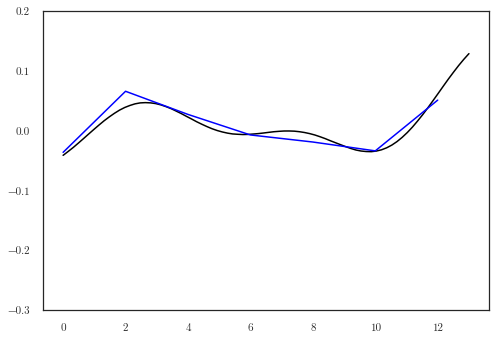

In [41]:
print(x)
lfm.eval()
grads = lfm(t_predict)
print('shape', grads.mean.detach().shape)
for i in range(1):
    plt.plot(t_predict, grads.mean.detach()[:, i], color='black')#.cumsum(dim=1))
    # plt.plot(t_predict, grads.mean.detach().cumsum(dim=0)[:, i])

plt.plot(t_grad, y_grad_target[:, 0], color='blue')
plt.ylim(-0.3, 0.2)

In [121]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_input, train_target, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_input, train_target, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad()
        self.base_kernel.lengthscale = 2.
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

train_input = data[0][0].view(-1, 1)
temp_train_target = torch.stack([
    data[1][0],
    torch.zeros_like(data[1][0]) # TODO [0] is for first time series
], -1)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)  # Value + Derivative
approximating_gp = GPModelWithDerivatives(train_input, temp_train_target, likelihood)
approximating_gp.double()
approximating_gp.train()
likelihood.train()

In [145]:
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': [
        *approximating_gp.parameters(),
        *lfm.parameters()
    ]},
], lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, approximating_gp)

In [146]:
approximating_gp.train()
lfm.train()
likelihood.train()

# with torch.no_grad():
#     approximating_gp.covar_module.base_kernel.lengthscale = 2.
def single_epoch(epoch=0):
    optimizer.zero_grad()

    # get gradients at all t
    grads = lfm(x)
    # plt.plot(grads.mean.detach().cumsum(dim=1).permute(1, 0))
    # plt.plot(grads.mean.detach())
    # get approximating GP at all t
    y_target = torch.stack([
            y[0], # values
            grads.mean[:, 0]  # grads TODO [0] is for first time series
    ], -1)
    approximating_gp.set_train_data(
        targets=y_target, strict=False
    )
    out = approximating_gp(approximating_gp.train_inputs[0])
    # plt.plot(out.mean[:, 0].detach())
    print(out.mean.shape, y_target.shape)
    # take loss and step
    loss = -mll(out, y_target)

    loss.backward()
    print('Epoch %d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        epoch, loss.item(),
        approximating_gp.covar_module.base_kernel.lengthscale.item(),
        approximating_gp.likelihood.noise.item()
    ))
    # print(lfm.basal_rate.view(-1))
    # print(lfm.decay_rate.view(-1))
    # print(lfm.sensitivity.view(-1))
    optimizer.step()

for i in range(100):
    single_epoch(i)

torch.Size([7, 2]) torch.Size([7, 2])
Epoch 0 - Loss: -2.634   lengthscale: 1.335   noise: 0.000
torch.Size([7, 2]) torch.Size([7, 2])
Epoch 1 - Loss: -4.104   lengthscale: 1.372   noise: 0.000
torch.Size([7, 2]) torch.Size([7, 2])
Epoch 2 - Loss: -4.086   lengthscale: 1.400   noise: 0.000
torch.Size([7, 2]) torch.Size([7, 2])
Epoch 3 - Loss: -3.740   lengthscale: 1.433   noise: 0.000
torch.Size([7, 2]) torch.Size([7, 2])
Epoch 4 - Loss: -3.945   lengthscale: 1.466   noise: 0.000
torch.Size([7, 2]) torch.Size([7, 2])
Epoch 5 - Loss: -4.378   lengthscale: 1.501   noise: 0.000
torch.Size([7, 2]) torch.Size([7, 2])
Epoch 6 - Loss: -4.708   lengthscale: 1.538   noise: 0.000
torch.Size([7, 2]) torch.Size([7, 2])
Epoch 7 - Loss: -4.764   lengthscale: 1.575   noise: 0.000
torch.Size([7, 2]) torch.Size([7, 2])
Epoch 8 - Loss: -4.672   lengthscale: 1.614   noise: 0.000
torch.Size([7, 2]) torch.Size([7, 2])
Epoch 9 - Loss: -4.699   lengthscale: 1.653   noise: 0.000
torch.Size([7, 2]) torch.Size(

In [147]:
print(lfm.basal_rate.view(-1))
print(lfm.decay_rate.view(-1))
print(lfm.sensitivity.view(-1))
# with torch.no_grad():
#     lfm.sensitivity += 0.3

tensor([0.8734, 0.3011, 0.3979, 0.1621, 0.7643], dtype=torch.float64,
       grad_fn=<ViewBackward>)
tensor([0.3840, 0.2197, 0.8913, 0.8000, 0.5992], dtype=torch.float64,
       grad_fn=<ViewBackward>)
tensor([-1.4326e-04,  6.4682e-02,  9.0406e-02,  1.0000e+00,  9.5463e-02],
       dtype=torch.float64, grad_fn=<ViewBackward>)


tensor(8.1197e-05, dtype=torch.float64)


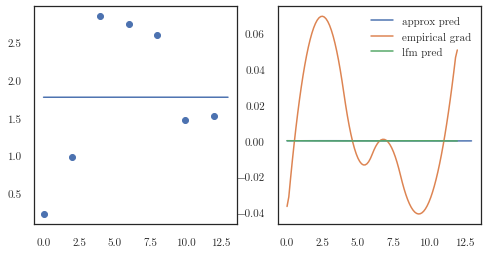

In [148]:
approximating_gp.eval()
lfm.eval()
grads = lfm(x)
mean_pred = approximating_gp(t_predict.double()).mean.detach()

print(mean_pred[:, 1].max())
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

axes[0].plot(t_predict, mean_pred[:, 0])
axes[0].scatter(dataset.t_observed, y[0])
axes[1].plot(t_predict, mean_pred[:, 1], label='approx pred')
axes[1].plot(t_interpolate, y_grad[0], label='empirical grad')
axes[1].plot(dataset.t_observed, grads.mean[:, 0].detach(), label='lfm pred')
axes[1].legend()

### Outputs prior to training:

torch.Size([80, 5, 1]) torch.Size([80]) torch.Size([80, 5, 80])
torch.Size([80, 5, 80])
samp torch.Size([80, 5, 80])
torch.Size([80, 5, 5])


ValueError: x and y must have same first dimension, but have shapes torch.Size([80]) and torch.Size([5])

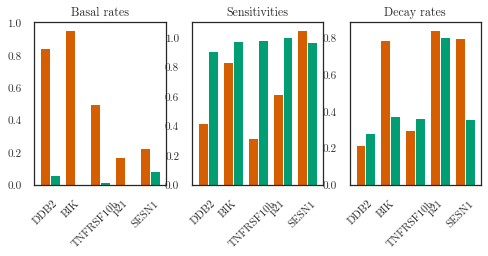

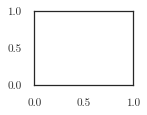

In [22]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['basal_rate', 'sensitivity', 'decay_rate']:
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())
q_m = lfm.predict_m(t_predict, step_size=step_size)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')


In [ ]:
lfm.train()

trainer.train(400, report_interval=10, step_size=step_size)


In [ ]:
lfm.eval()
q_m = lfm.predict_m(t_predict, step_size=step_size)
q_f = lfm.predict_f(t_predict)

plotter.plot_losses(trainer, last_x=200)
plotter.plot_gp(q_m, t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-2, 3.2), num_samples=3)
plt.title('Latent')

labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['basal_rate', 'sensitivity', 'decay_rate']:
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())